In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

2025-03-12 22:05:45.295251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 22:05:45.382998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741791945.415249  118662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741791945.425244  118662 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 22:05:45.501456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled.


In [4]:
# Load dataset paths
X_train_path = "/media/tairo/Storages/DataSetAnimals/.npy format(-11)/X_train.npy"
y_train_path = "/media/tairo/Storages/DataSetAnimals/.npy format(-11)/y_train.npy"
X_val_path = "/media/tairo/Storages/DataSetAnimals/.npy format(-11)/X_val.npy"
y_val_path = "/media/tairo/Storages/DataSetAnimals/.npy format(-11)/y_val.npy"

In [5]:
# Load dataset
X_train = np.load(X_train_path)
y_train = np.load(y_train_path)
X_val = np.load(X_val_path)
y_val = np.load(y_val_path)


In [6]:
# Detect number of classes
class_indices = np.unique(y_train)
num_classes = len(class_indices)

# Create a class mapping (assumes class labels are integers: 0, 1, 2, ...)
class_map = {idx: f"Class_{idx}" for idx in class_indices}  

In [7]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))  
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [8]:
# Print class information
print(f"Detected {num_classes} classes:", class_map)
print("\nTrain Labels:", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Validation Labels:", np.unique(np.argmax(y_val, axis=1), return_counts=True))

Detected 3 classes: {np.int64(0): 'Class_0', np.int64(1): 'Class_1', np.int64(2): 'Class_2'}

Train Labels: (array([0, 1, 2]), array([700, 700, 700]))
Validation Labels: (array([0, 1, 2]), array([200, 200, 200]))


In [9]:

# Define batch size (reduce to fit in GPU memory)
BATCH_SIZE = 4  # Reduce from 32 to avoid GPU memory overflow

# Convert NumPy arrays into TensorFlow dataset (streaming)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1741791954.354944  118662 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1841 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
def build_resnet50(input_shape=(224, 224, 3), num_classes=4, reg_strength=0.0005):
    # Load ResNet50 Pretrained Model (Without Fully Connected Top Layers)
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
    
    # Freeze base model layers initially
    base_model.trainable = False  
    
    # Extract features from ResNet50
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling

    # Fully Connected Layers (64 → 32 → 16)
    x = Dense(32, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(16, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(8, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Final Classification Layer
    outputs = Dense(num_classes, activation='softmax', dtype="float32", kernel_regularizer=l2(reg_strength))(x)

    # Build Model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [11]:
# Build the VGG16 model
model = build_resnet50(input_shape=(224, 224, 3), num_classes=num_classes)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [13]:
# Define callbacks
BEST_MODEL_PATH = "VGG16(1).keras"

checkpoint = ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="min", verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

In [14]:
with tf.device('/GPU:0'):  # Forces GPU usage
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=200,  # Increase if needed
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

Epoch 1/200


I0000 00:00:1741791968.705070  124606 service.cc:148] XLA service 0x787d34001b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741791968.711270  124606 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-12 22:06:08.876266: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741791969.854223  124606 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-12 22:06:12.696870: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 61.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  6/525 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3917 - loss: 1.2769 

I0000 00:00:1741791974.834239  124606 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3578 - loss: 1.3358
Epoch 1: val_loss improved from inf to 1.24825, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3578 - loss: 1.3355 - val_accuracy: 0.3867 - val_loss: 1.2483 - learning_rate: 0.0010
Epoch 2/200
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4061 - loss: 1.1731
Epoch 2: val_loss improved from 1.24825 to 1.05642, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.4061 - loss: 1.1730 - val_accuracy: 0.4650 - val_loss: 1.0564 - learning_rate: 0.0010
Epoch 3/200
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4340 - loss: 1.1210
Epoch 3: val_loss improved from 1.05642 to 0.92718, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.4342 - loss: 1.1209 - val_accuracy: 0.6117 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 4/200
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4828 -

In [15]:
# Load the best saved model
best_model = load_model(BEST_MODEL_PATH)

In [16]:
# Evaluate on validation set
val_loss, val_acc = best_model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9415 - loss: 0.3779
Validation Accuracy: 92.67%


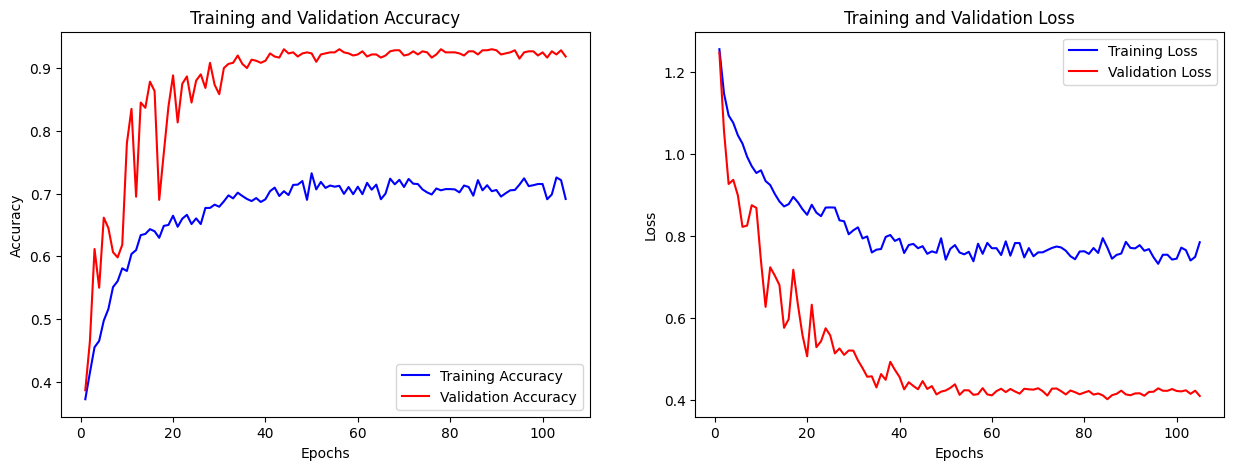

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
axs[0].plot(epochs, train_acc, 'b', label='Training Accuracy')
axs[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Loss
axs[1].plot(epochs, train_loss, 'b', label='Training Loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.show()